# 🛠️ Kirundi Dataset Manager

## 👋 Introduction
Welcome to the **Kirundi Dataset Manager**. This notebook is your control center for managing the `metadata.csv` file. 

### 🎯 Objectives
1.  **Audit Data Health:** Instantly see how much of your dataset is translated and categorized.
2.  **Clean & Validate:** Find duplicates, weird characters, and outliers.
3.  **Prioritize Work:** Sort the data so the most complete rows are at the top (Tier 0) and the ones needing work are at the bottom.
4.  **Prepare for AI:** Get the data ready for LLM processing.

---

## 1. ⚙️ Initialization & Configuration
**What this block does:**  
It imports all the necessary Python libraries (tools) we need, like `pandas` for data handling and `matplotlib` for graphs. It also sets up the file paths for your CSV file and the backup folder.

**Why it's important:**  
Without this, the rest of the code won't know where your file is or what tools to use.

In [58]:
# --- IMPORTS ---
import pandas as pd              # For handling the dataset (tables)
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For creating charts
import seaborn as sns            # For making charts look beautiful
import os                        # For interacting with the operating system (files)
import shutil                    # For copying files (backups)
import re                        # For text pattern matching (Regex)
from datetime import datetime    # For getting the current date/time
from deep_translator import GoogleTranslator # For AI translation
from unidecode import unidecode  # For text cleaning

# --- CONFIGURATION ---
# The path to your main data file
FILE_PATH = '/home/samandari/Documents/ASYST/Perso/Kirundi_Dataset/metadata.csv'

# The folder where we will save safety backups
BACKUP_DIR = '/home/samandari/Documents/ASYST/Perso/Kirundi_Dataset/backups'

# --- DISPLAY SETTINGS ---
# These settings make the output in the notebook easier to read
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Create the backup directory if it doesn't exist yet
os.makedirs(BACKUP_DIR, exist_ok=True)

print("✅ Initialization Complete. Libraries loaded and paths set.")

✅ Initialization Complete. Libraries loaded and paths set.


## 2. 📂 Data Loading & Safety Backup
**What this block does:**  
Before we touch anything, this block **creates a copy** of your `metadata.csv` file in the `backups` folder. It names the backup with the current date and time (e.g., `metadata_backup_20231129...`). Then, it loads the data into memory.

**Why it's important:**  
Safety first! If we accidentally mess up the data, we can always restore it from the backup.

In [59]:
def create_backup(file_path, backup_dir):
    """Creates a timestamped copy of the file."""
    if os.path.exists(file_path):
        # Generate a unique name with the current time
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_name = f"metadata_backup_{timestamp}.csv"
        backup_path = os.path.join(backup_dir, backup_name)
        
        # Copy the file
        shutil.copy2(file_path, backup_path)
        print(f"✅ Safety Backup created at: {backup_path}")
    else:
        print(f"⚠️ Warning: File not found at {file_path}. Cannot back up.")

# --- EXECUTION ---
if os.path.exists(FILE_PATH):
    # 1. Make the backup
    create_backup(FILE_PATH, BACKUP_DIR)
    
    # 2. Load the CSV into a pandas DataFrame (df)
    df = pd.read_csv(FILE_PATH)
    print(f"\n📂 Dataset Successfully Loaded!")
    print(f"   - Rows: {df.shape[0]}")
    print(f"   - Columns: {df.shape[1]}")
    
    # 3. Ensure all required columns exist
    required_cols = ['Machine_Suggestion', 'Source', 'Duration']
    for col in required_cols:
        if col not in df.columns:
            df[col] = "" if col != 'Machine_Suggestion' else np.nan
            print(f"   ➕ Added missing column: '{col}'")
            
    # 4. We define the preferred order for the main columns
    preferred_order = [
        'File_Path', 'Kirundi_Transcription', 'French_Translation', 'English_Translation', 
        'Domain', 'Machine_Suggestion', 'Source', 'Duration', 
        'Speaker_id', 'Age', 'Gender'
    ]
    
    # Reorder columns: Keep preferred ones first, then append any others found in the file
    existing_cols = df.columns.tolist()
    new_order = [c for c in preferred_order if c in existing_cols] + [c for c in existing_cols if c not in preferred_order]
    df = df[new_order]
    
    # 5. Clean unwanted columns if they exist
    unwanted_cols = ['has_FR', 'has_EN', 'has_DOMAIN', 'Completion_Tier', 'Kirundi_Length', 'char_count']
    df.drop(columns=[c for c in unwanted_cols if c in df.columns], inplace=True, errors='ignore')
    
    print("   🔄 Columns reordered to standard format.")
    
else:
    print(f"❌ CRITICAL ERROR: Dataset not found at {FILE_PATH}")

✅ Safety Backup created at: /home/samandari/Documents/ASYST/Perso/Kirundi_Dataset/backups/metadata_backup_20251130_115335.csv

📂 Dataset Successfully Loaded!
   - Rows: 3683
   - Columns: 13
   🔄 Columns reordered to standard format.


## 3. 📊 Data Audit & Health Check
**What this block does:**  
This function scans your dataset to calculate "Health Metrics". It counts how many rows have French translations, English translations, Domain tags, Sources, and Durations.

**Why it's important:**  
This gives you a high-level overview of your progress. You can see exactly how much work is left to do.

In [60]:
def check_filled(series):
    """Helper function: Returns True if a cell is not empty and not just whitespace."""
    return series.notna() & (series.astype(str).str.strip() != "")

def audit_dataset(df):
    print("\n📊 --- DATASET HEALTH REPORT ---")
    
    total = len(df)
    
    # Calculate counts for each key column
    has_fr = check_filled(df['French_Translation']).sum()
    has_en = check_filled(df['English_Translation']).sum()
    has_domain = check_filled(df['Domain']).sum()
    has_source = check_filled(df['Source']).sum()
    # has_duration = check_filled(df['Duration']).sum()
    
    # Display results
    print(f"Total Sentences: {total}")
    print(f"✅ French Translations: {has_fr} ({has_fr/total:.1%})")
    print(f"✅ English Translations: {has_en} ({has_en/total:.1%})")
    print(f"✅ Domains Assigned:    {has_domain} ({has_domain/total:.1%})")
    print(f"✅ Sources Logged:      {has_source} ({has_source/total:.1%})")
    # print(f"✅ Durations Logged:    {has_duration} ({has_duration/total:.1%})")

# Run the audit
audit_dataset(df)


📊 --- DATASET HEALTH REPORT ---
Total Sentences: 3683
✅ French Translations: 2329 (63.2%)
✅ English Translations: 2329 (63.2%)
✅ Domains Assigned:    3683 (100.0%)
✅ Sources Logged:      0 (0.0%)


## 4. 🔍 Deep Dive: Duplicate Analysis
**What this block does:**  
It checks the `Kirundi_Transcription` column for any repeated sentences. If it finds any, it prints them out so you can see them.

**Why it's important:**  
Duplicates waste translator time and can confuse machine learning models. We want every sentence to be unique.

In [45]:
def show_duplicates(df):
    """Identifies and displays duplicate Kirundi sentences."""
    print("\n🔍 Checking for Duplicates...")
    
    # Find rows where Kirundi_Transcription appears more than once
    duplicates = df[df.duplicated(subset=['Kirundi_Transcription'], keep=False)]
    
    if not duplicates.empty:
        count = len(duplicates)
        print(f"⚠️ FOUND {count} DUPLICATE ENTRIES! Listing below:")
        # Show the duplicates sorted so they appear next to each other
        print(duplicates[['Kirundi_Transcription', 'French_Translation']].sort_values(by='Kirundi_Transcription'))
    else:
        print("✅ Excellent! No duplicate sentences found.")

show_duplicates(df)


🔍 Checking for Duplicates...
✅ Excellent! No duplicate sentences found.


## 5. 🥧 Visualization: Completion Tiers
**What this block does:**  
It creates a **Pie Chart** showing the proportion of your dataset in three categories:
*   **Complete (Tier 0):** Has French, English, and Domain.
*   **Partial (Tier 1):** Has French, but missing English or Domain.
*   **Needs Work (Tier 2):** Missing the core French translation.

**Why it's important:**  
Visuals make it easier to understand the "completeness" of your project at a glance.


📊 Generating Completion Chart...


/home/samandari/media/StarK/Programs/SetUps/AI/AI_Journey/I.Udemy - The AI Engineer Course 2025 Complete AI Engineer Bootcamp 2025-5/Files/LangChain/langchain_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/samandari/media/StarK/Programs/SetUps/AI/AI_Journey/I.Udemy - The AI Engineer Course 2025 Complete AI Engineer Bootcamp 2025-5/Files/LangChain/langchain_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/samandari/media/StarK/Programs/SetUps/AI/AI_Journey/I.Udemy - The AI Engineer Course 2025 Complete AI Engineer Bootcamp 2025-5/Files/LangChain/langchain_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Dej

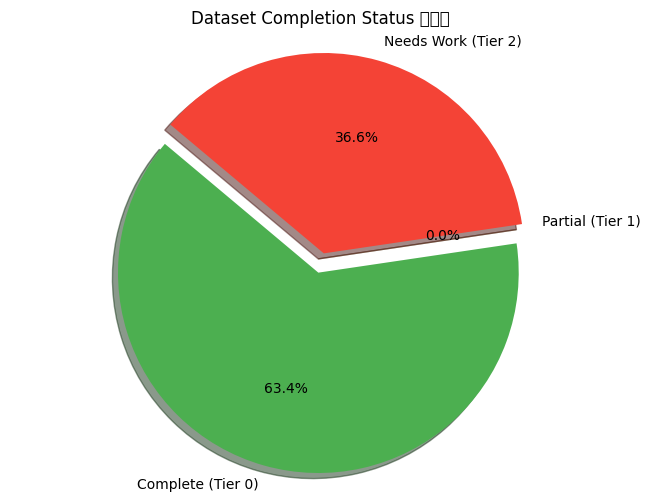

   - Tier 0 (Done)🟢: 2359
   - Tier 1 (Partial)🟡: 0
   - Tier 2 (Empty)🔴: 1359


In [25]:
def plot_completion_tiers(df):
    """Generates a pie chart of completion status."""
    print("\n📊 Generating Completion Chart...")
    
    # Calculate Tier Counts
    tier_0 = df[check_filled(df['French_Translation']) & 
                check_filled(df['English_Translation']) & 
                check_filled(df['Domain'])].shape[0]
    
    tier_1 = df[check_filled(df['French_Translation'])].shape[0] - tier_0
    tier_2 = len(df) - (tier_0 + tier_1)
    
    # Plotting Configuration
    labels = ['Complete (Tier 0)', 'Partial (Tier 1)', 'Needs Work (Tier 2)']
    sizes = [tier_0, tier_1, tier_2]
    colors = ['#4CAF50', '#FFC107', '#F44336'] # Green, Amber, Red
    explode = (0.1, 0, 0)  # "Explode" the first slice to highlight it

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Dataset Completion Status 🟢🟡🔴')
    plt.show()
    
    print(f"   - Tier 0 (Done)🟢: {tier_0}")
    print(f"   - Tier 1 (Partial)🟡: {tier_1}")
    print(f"   - Tier 2 (Empty)🔴: {tier_2}")

plot_completion_tiers(df)

## 6. 📈 Visualization: Domain Distribution
**What this block does:**  
It creates a **Bar Chart** showing how many sentences belong to each Domain (e.g., 'jokes', 'proverbs', 'daily_life').

**Why it's important:**  
This helps you see if your dataset is balanced. If one domain has too few sentences, you might want to collect more data for that topic.


📊 Generating Domain Distribution Chart...


/tmp/ipykernel_11965/925530791.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')


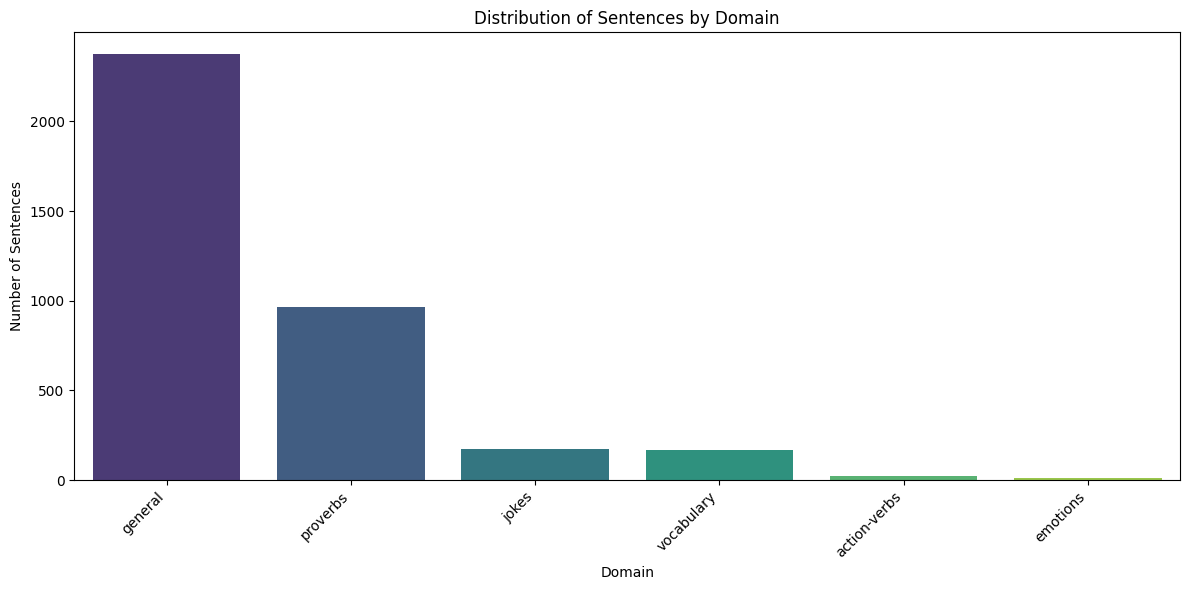

Top 5 Domains:
Domain
general         2378
proverbs         965
jokes            173
vocabulary       166
action-verbs      25
Name: count, dtype: int64


In [26]:
def plot_domain_distribution(df):
    """Generates a bar chart of domain counts."""
    print("\n📊 Generating Domain Distribution Chart...")
    
    plt.figure(figsize=(12, 6))
    domain_counts = df['Domain'].value_counts()
    
    # Create Bar Plot
    sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')
    
    plt.title('Distribution of Sentences by Domain')
    plt.xlabel('Domain')
    plt.ylabel('Number of Sentences')
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout()
    plt.show()
    
    print("Top 5 Domains:")
    print(domain_counts.head(5))

plot_domain_distribution(df)

## 7. 📏 Quality Control: Sentence Length (Characters)
**What this block does:**  
It calculates the length (in characters) of every Kirundi sentence and plots a histogram. It also flags sentences that are suspiciously short (less than 10 chars) or long (more than 200 chars).

**Why it's important:**  
Extremely short sentences might be noise (e.g., "Ah."). Extremely long sentences might be errors or multiple sentences pasted together.


📏 Analyzing Sentence Lengths (Characters)...


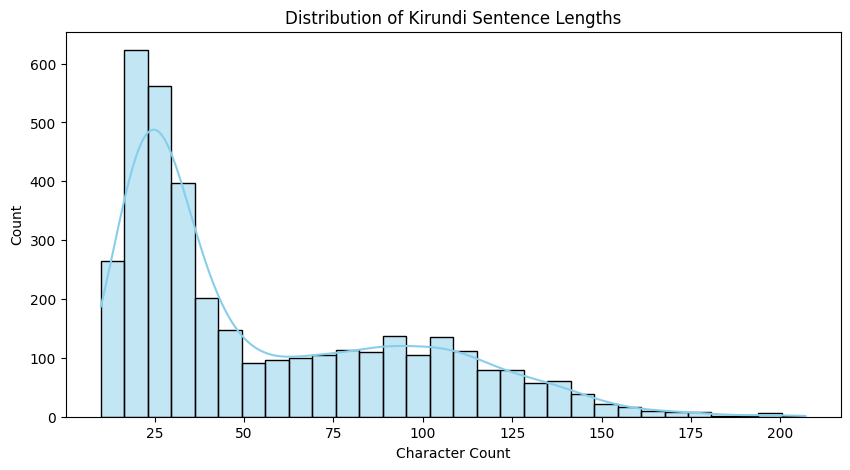

⚠️ Very Short Sentences (<10 chars): 0
⚠️ Very Long Sentences (>200 chars): 1

--- Détails : 1 Lignes TROP LONGUES (à découper pour l'audio) ---
🔴 LIGNE 1020 | Exact line in Metadata 1019 :
 Mìísi yöse iyó uvuzé kó watāyé amaherá/urupfūnguruzo, ntihīgéra hábura umūntu uzá wûmva akúbajije ngo "Wayatāye/warutāye hêhé?", nkâhó umèénga iyâbá uzí ahó wayatàáye/warutàáye ntūbá wâgīye kuyátōra/kurútōra : jokes

 Lignes à revoir (Trop courtes ou trop longues):
 [1020] 

--- Analyse de Longueur Terminée ---


In [ ]:
def analyze_char_length(df):
    """Analyzes the character count of Kirundi sentences and lists problematic rows."""
    print("\n📏 Analyzing Sentence Lengths (Characters)...")
    
    # Calculate length for each row
    df['char_count'] = df['Kirundi_Transcription'].astype(str).apply(len)
    
    # Define thresholds
    short_threshold = 10
    long_threshold = 200
    
    # Identify problematic rows using masks
    short_mask = df['char_count'] < short_threshold
    long_mask = df['char_count'] > long_threshold
    
    short_count = len(df[short_mask])
    long_count = len(df[long_mask])

     # Plot Histogram

    plt.figure(figsize=(10, 5))

    sns.histplot(df['char_count'], bins=30, kde=True, color='skyblue')

    plt.title('Distribution of Kirundi Sentence Lengths')

    plt.xlabel('Character Count')

    plt.show() 
    
    print(f"⚠️ Very Short Sentences (<{short_threshold} chars): {short_count}")
    print(f"⚠️ Very Long Sentences (>{long_threshold} chars): {long_count}")

    to_be_review = []
    
    # --- NOUVEAU BLOC : Afficher les détails des phrases courtes ---
    if short_count > 0:
        print(f"\n--- Détails : {short_count} Lignes TROP COURTES (à vérifier pour la qualité audio) ---")
        
        for index, row in df[short_mask].iterrows():
            # index est l'index Pandas (0-based)
            # Pour corriger le décalage, nous utilisons index + 1 (qui est le numéro de ligne sans l'en-tête)
            # LIGNE CSV = index + 2. Si LIGNE CSV est décalée, LIGNE A SUPPRIMER = index + 1
            line_number_for_delete = index + 2
            
            # Afficher l'index interne de Pandas et le numéro de ligne théorique
            print(f"🔴 LIGNE {line_number_for_delete} | Exact line in Metadata {line_number_for_delete - 1}: {row['Kirundi_Transcription']} : {row['Domain']}")
            to_be_review.append(line_number_for_delete)

    # --- NOUVEAU BLOC : Afficher les détails des phrases longues ---
    if long_count > 0:
        print(f"\n--- Détails : {long_count} Lignes TROP LONGUES (à découper pour l'audio) ---")
        for index, row in df[long_mask].iterrows():
            line_number_for_delete = index + 2
            print(f"🔴 LIGNE {line_number_for_delete} | Exact line in Metadata {line_number_for_delete - 1} :\n {row['Kirundi_Transcription']} : {row['Domain']}")
            to_be_review.append(line_number_for_delete)
            
    print(f"\n Lignes à revoir (Trop courtes ou trop longues):\n {to_be_review} ")
    print("\n--- Analyse de Longueur Terminée ---")
    
    return to_be_review # Return the list of line numbers for easy copying"
to_be_deleted = analyze_char_length(df)


**What this block does:**  
It takes in parameter a list of Rows numbers and delete each one

**Why it's important:**  
We manually add the List from above to avoid delete datas we can correct

### Remember to reload the Dataset to get changes!!!

In [47]:

def delete_rows_by_number(line_numbers_to_delete):
    """Deletes rows from the metadata.csv based on given line numbers."""
    
    initial_count = len(df)

    
    # Filtrer les numéros de ligne invalides (comme 1 pour le header)
    valid_line_numbers = [n for n in line_numbers_to_delete if n >= 2]
    indices_to_delete = [n - 2 for n in valid_line_numbers]
    
    # 3. Supprimer les lignes
    df_cleaned = df.drop(index=indices_to_delete, errors='ignore')
    
    final_count = len(df_cleaned)
    deleted_count = initial_count - final_count

    if deleted_count > 0:
        # 4. Sauvegarder la nouvelle version
        df_cleaned.to_csv(FILE_PATH, index=False, encoding='utf-8-sig')
        print(f"🎉 SUCCÈS : Supprimé {deleted_count} ligne(s) du fichier metadata.csv.")
        print(f"   Lignes restantes : {final_count}")
    else:
        print("Rien à supprimer ou numéros de ligne non trouvés.")


delete_rows = []
delete_rows_by_number(delete_rows)


Rien à supprimer ou numéros de ligne non trouvés.


## 8. 📝 Quality Control: Word Count Analysis
**What this block does:**  
Similar to the character count, this counts the number of **words** in each sentence.

**Why it's important:**  
This helps assess the complexity of the dataset. A dataset with mostly 1-word sentences is very different from one with 20-word sentences.


📝 Analyzing Word Counts...


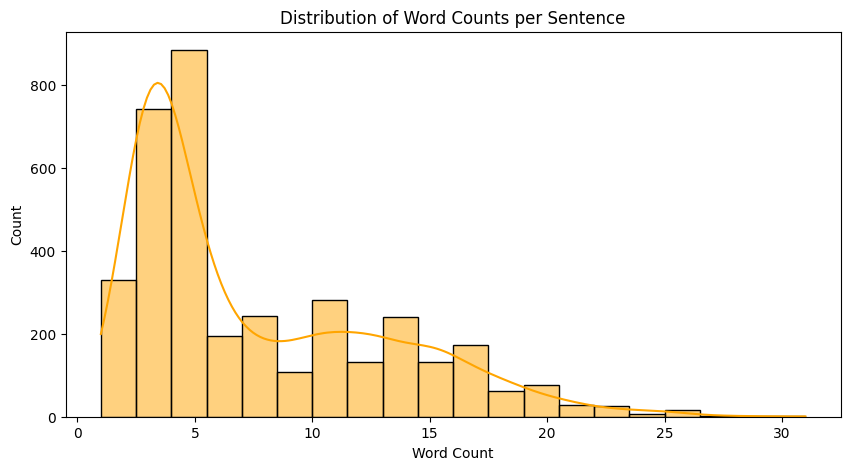

📊 Average Word Count: 7.55 words/sentence


In [48]:
def analyze_word_count(df):
    """Analyzes the word count per sentence."""
    print("\n📝 Analyzing Word Counts...")
    
    # Split by space to approximate word count
    df['word_count'] = df['Kirundi_Transcription'].astype(str).apply(lambda x: len(x.split()))
    
    # Plot Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(df['word_count'], bins=20, kde=True, color='orange')
    plt.title('Distribution of Word Counts per Sentence')
    plt.xlabel('Word Count')
    plt.show()
    
    avg_words = df['word_count'].mean()
    print(f"📊 Average Word Count: {avg_words:.2f} words/sentence")

analyze_word_count(df)

## 9. 🧐 Quality Control: Character Validation
**What this block does:**  
It uses a "Regular Expression" (Regex) to scan for characters that don't look like standard text (e.g., emojis, weird symbols, or non-Latin characters).

**Why it's important:**  
Data cleanliness is key for AI. Emojis or formatting artifacts can break training pipelines.

In [49]:
def validate_characters(df):
    """Checks for potentially invalid characters in Kirundi text."""
    print("\n🧐 Validating Characters...")
    
    # Regex pattern: Matches anything that IS NOT a letter, number, space, or common punctuation.
    # This will catch emojis, brackets [], or unusual symbols.
    suspicious_pattern = r'[^a-zA-Z0-9\s.,?!\'"\-éèàùîôâêûíóúñ]'
    
    suspicious_rows = df[df['Kirundi_Transcription'].astype(str).str.contains(suspicious_pattern, regex=True)]
    
    count = len(suspicious_rows)
    print(f"Found {count} rows with potentially special characters (e.g., emojis, brackets).")
    
    if not suspicious_rows.empty:
        print("--- Sample of Suspicious Rows ---")
        print(suspicious_rows[['Kirundi_Transcription']].head(5))

validate_characters(df)


🧐 Validating Characters...
Found 1981 rows with potentially special characters (e.g., emojis, brackets).
--- Sample of Suspicious Rows ---
                                                                                                                Kirundi_Transcription
0  "Ni wewé watōyé aryá maherá yarí ku kabàáti???"\n- Inyishú isānzwé: Oya sí jēwé!\n- Umurùúndi: Indé? Jēwé? Nayatōye hábona ndé????
1                                                                                            - "Ivyo birāto wāmbáye wabíguze angâhé?"
2                                                                                                    - Arasúbizayó ati : Miré umuriro
3                                                                                - Bella : Hèé màá, utânguriye iphone 13 nca nîyahura
4                                                                                              - Bubu : Alooo Muyòómba !! úrakomeye ?


## 10. 🤖 AI Augmentation Pipeline
**What this block does:**  
This prepares the dataset for AI assistance. It identifies rows that are missing translations (Tier 2) and checks if the `Machine_Suggestion` column is ready to receive AI-generated drafts.

**Why it's important:**  
This is the bridge between manual data entry and AI automation.

In [50]:
def generate_machine_suggestions(df):
    """Prepares rows for AI processing."""
    print("\n🤖 --- AI AUGMENTATION PIPELINE ---")
    
    # Find rows missing French
    tier_2_mask = ~check_filled(df['French_Translation'])
    count = tier_2_mask.sum()
    print(f"🎯 Found {count} rows requiring AI suggestions.")
    
    # Check how many of these are empty in the Machine_Suggestion column
    empty_suggestion_mask = tier_2_mask & ~check_filled(df['Machine_Suggestion'])
    rows_to_update = df[empty_suggestion_mask].shape[0]
    
    if rows_to_update > 0:
        print(f"📝 {rows_to_update} rows are ready for LLM processing (Machine_Suggestion is empty).")
    else:
        print("👍 All Tier 2 rows already have content in 'Machine_Suggestion'.")
        
    return df

df = generate_machine_suggestions(df)


🤖 --- AI AUGMENTATION PIPELINE ---
🎯 Found 1354 rows requiring AI suggestions.
👍 All Tier 2 rows already have content in 'Machine_Suggestion'.


## 11. Utility and AI Functions
These functions help clean text before translation and load the data correctly.

In [52]:
MASTER_COLUMNS = preferred_order
def clean_for_translation(text):
    """Cleans text for Google Translate."""
    if pd.isna(text): return ""
    clean = unidecode(str(text))
    return clean

def normalize_text(text):
    """Cleans text for robust comparison."""
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def load_master_data():
    
    df['normalized_kirundi'] = df['Kirundi_Transcription'].apply(lambda x: normalize_text(x) if pd.notna(x) else "")
        
    print(f"📂 Master file loaded: {len(df)} rows.")
    return df

def cleanup_completed_hints(df):
    """Removes AI suggestions from rows that now have a human translation."""
    cleaned_count = 0
    print("\n🧹 STEP 1: CLEANUP (Removing old AI hints)...")

    # Rows that have a human translation (French) AND an AI suggestion
    mask = (df['French_Translation'].notna() & (df['French_Translation'].str.strip() != "")) & \
           (df['Machine_Suggestion'].notna() & (df['Machine_Suggestion'].str.strip() != ""))
    
    hints_to_clean = df[mask].index
    
    if not hints_to_clean.empty:
        df.loc[hints_to_clean, 'Machine_Suggestion'] = ""
        cleaned_count = len(hints_to_clean)
    
    print(f"✅ CLEANUP COMPLETE: Removed {cleaned_count} old AI suggestions.")
    return df, cleaned_count

def generate_new_hints(df, filepath):
    """Generates new French AI hints for rows missing both a translation and a hint."""
    translator = GoogleTranslator(source='auto', target='fr')
    count = 0
    
    print("\n🤖 STEP 2: GENERATING FRENCH HINTS...")
    
    # Find rows that need a French hint
    rows_to_translate = df[
        df['Kirundi_Transcription'].notna() & 
        (df['French_Translation'].isna() | (df['French_Translation'].str.strip() == "")) &
        (df['Machine_Suggestion'].isna() | (df['Machine_Suggestion'].str.strip() == ""))
    ]
    
    if rows_to_translate.empty:
        print("No new rows found that require French AI suggestions.")
        return df, 0

    print(f"Found {len(rows_to_translate)} rows to translate. Starting...")

    for index, row in rows_to_translate.iterrows():
        kirundi_text = row['Kirundi_Transcription']
        
        try:
            clean_text = clean_for_translation(kirundi_text)
            
            if clean_text:
                translation = translator.translate(clean_text)
                df.loc[index, 'Machine_Suggestion'] = translation
                count += 1
                print(f"[{count}] Kirundi: {clean_text[:30]}... -> French Hint: {translation[:30]}...")
                time.sleep(0.2)
                
                if count % 50 == 0: # Save less frequently for large runs
                     df.to_csv(filepath, index=False, encoding='utf-8-sig')

        except Exception as e:
            print(f"Error translating row {index}: {e}")

    print(f"✅ GENERATION COMPLETE: Created {count} new French suggestions.")
    return df, count

def generate_english_hints(df):
    """Translates existing French text into English"""
    
    translator = GoogleTranslator(source='fr', target='en')
    count = 0
    
    print("\n🌐 STEP 4: AUTO-GENERATION OF ENGLISH TRANSLATIONS...")

    # Mask: Find rows that have French (non-empty) BUT no English (empty)
    mask = (df['French_Translation'].notna()) & (df['French_Translation'].str.strip() != "") & \
           (df['English_Translation'].isna() | (df['English_Translation'].str.strip() == ""))
    
    rows_to_translate = df[mask].copy()
    total_to_translate = len(rows_to_translate)
    
    if rows_to_translate.empty:
        print("No rows found that require French -> English translation.")
        return df
    
    print(f"Found {len(rows_to_translate)} rows to translate into English...")

    for index, row in rows_to_translate.iterrows():
        french_text = row['French_Translation']
        
        try:
            clean_french = french_text.replace('"', '').strip()
            
            if clean_french:
                english_translation = translator.translate(clean_french)
                
                df.loc[index, 'English_Translation'] = english_translation
                
                count += 1
                print(f"[{count}/{total_to_translate}] FR->EN: '{clean_french[:40]}...' -> '{english_translation[:20]}...'", flush=True)
                time.sleep(0.2)
                
        except Exception as e:
            print(f"Error translating French->English at index {index}: {e}")

    print(f"✅ ENGLISH TRANSLATION COMPLETE: {count} rows translated.")
    return df

def fill_missing_domains(df, default_domain="general"):
    """Automatically fills empty 'Domain' cells."""
    print(f"\n🏷️ STEP 5: BACKFILLING DOMAINS (Default: '{default_domain}')...")
    empty_mask = df['Domain'].isna() | (df['Domain'].astype(str).str.strip() == "")
    empty_count = empty_mask.sum()
    
    if empty_count > 0:
        df['Domain'] = df['Domain'].fillna(default_domain)
        df.loc[df['Domain'].astype(str).str.strip() == "", 'Domain'] = default_domain
        print(f"✅ Auto-filled {empty_count} rows with domain '{default_domain}'.")
    else:
        print("All rows already have a domain.")
        
    return df



## 12. 🔎 Search Utility
**What this block does:**  
It defines a function `search_dataset(df, query)` that allows you to search for any word or phrase across Kirundi, French, and English columns.

**Why it's important:**  
Useful for quickly checking if a specific sentence or word already exists in the dataset.

In [70]:

def check_filled(series):
    """Helper function to check if a cell is filled (not NaN and not an empty string)."""
    return series.notna() & (series.astype(str).str.strip() != "")

def search_dataset(df, query):
    """
    Search for a keyword in Kirundi, French, or English columns 
    and prints the exact Pandas index for deletion/update.
    """
    print(f"\n🔎 Searching for '{query}'...")
    query = str(query).lower()
    
    # Create a mask checking all 3 relevant text columns
    mask = (
        df['Kirundi_Transcription'].str.lower().str.contains(query, na=False) |
        df['French_Translation'].str.lower().str.contains(query, na=False) |
        df['English_Translation'].str.lower().str.contains(query, na=False)
    )
    
    results = df[mask]
    
    print(f"   Found {len(results)} matches.")
    
    if not results.empty:
        # We need to display the INDEX (the number to use for update)
        display_cols = ['Kirundi_Transcription', 'French_Translation', 'Domain']
        
        # Display the DataFrame with the Pandas index showing
        with pd.option_context('display.max_rows', 10, 'display.max_colwidth', 80):
            print("\n--- Results (Use the leftmost Index number for updating) ---")
            print(results[display_cols].head())


search_dataset(df, 'Samandari') 



🔎 Searching for 'Samandari'...
   Found 2 matches.

--- Results (Use the leftmost Index number for updating) ---
                                                                Kirundi_Transcription       French_Translation   Domain
2290                                                                  nitwa Samandari  Je m'appelle Samandari.  general
2564  Bugorovye, twateramiye kwa sogokuru, araducurarangira inanga yongera araduci...                      NaN  general


## 12. 🔎 Update Utility
**What this block does:**  
It defines a function `update_row_by_index(df, index_to_update, column, new_value)` that allows you to update for any word or phrase across Metadata.csv

**Why it's important:**  
Useful for quickly updating.

In [ ]:

def update_row_by_index(df, index_to_update, column, new_value):
    """
    Updates a specific cell in the DataFrame based on its Pandas index, 
    then recalculates normalization and saves the CSV.
    """
    
    index_to_update = int(index_to_update)
    column = str(column).strip()
    
    if index_to_update not in df.index:
        print(f"❌ ERROR: Index {index_to_update} not found in the DataFrame. Please check the index number.")
        return df

    if column not in df.columns:
        print(f"❌ ERROR: Column '{column}' not found. Valid columns are: {list(df.columns)}")
        return df

    # Store old value for logging
    old_value = df.loc[index_to_update, column]
    
    # 1. Update the value
    df.loc[index_to_update, column] = str(new_value).strip() if new_value is not None else None
    
    # 2. Recalculate normalization if Kirundi Transcription was updated
    if column == 'Kirundi_Transcription':
        df.loc[index_to_update, 'normalized_kirundi'] = normalize_text(new_value)
    
    # 3. Save the DataFrame back to the CSV file
    try:
        # Drop the temporary helper column before saving
        df_to_save = df.drop(columns=['normalized_kirundi', 'char_count', 'Completion_Tier'], errors='ignore')
        df_to_save.to_csv(FILE_PATH, index=False, encoding='utf-8-sig')
        
        print(f"\n✅ SUCCESS: Row {index_to_update} updated and saved to {FILE_PATH}.")
        print(f"   Column: {column}")
        print(f"   Old Value: '{old_value[:40]}'...")
        print(f"   New Value: '{new_value[:40]}'...")
        
    except Exception as e:
        print(f"❌ CRITICAL ERROR: Could not save the file. {e}")

    return df # Return the modified DataFrame for continuous use

# Uncomment and add the number manually
# df = update_row_by_index(df, 
#                          index_to_update=2290, 
#                          column='Kirundi_Transcription', 
#                          new_value='nitwa Samandari'
#                         )



🔎 Searching for 'Samandari'...
   Found 2 matches.

--- Results (Use the leftmost Index number for updating) ---
                                                                Kirundi_Transcription       French_Translation   Domain
2290                                                                  nitwa samandari  Je m'appelle Samandari.  general
2564  Bugorovye, twateramiye kwa sogokuru, araducurarangira inanga yongera araduci...                      NaN  general

✅ SUCCESS: Row 2290 updated and saved to /home/samandari/Documents/ASYST/Perso/Kirundi_Dataset/metadata.csv.
   Column: Kirundi_Transcription
   Old Value: 'nitwa samandari'...
   New Value: 'nitwa Samandari'...


## 13. 🔄 Sorting Logic (The Core Feature)
**What this block does:**  
This is the main logic for organizing the file. It sorts the rows based on "Completeness Priority":
1.  **Priority 0 (Top):** Fully complete rows.
2.  **Priority 1 (Middle):** Rows that have French but need English/Domain.
3.  **Priority 2 (Bottom):** Rows that are missing the main French translation.

**Why it's important:**  
This keeps the "finished" work at the top and the "to-do" list at the bottom, making the file much easier to read and manage.

In [53]:
def sort_dataframe_for_readability(df):
    """
    Sorts the dataframe using a 3-level priority:
    0: Fully Complete (FR + EN + Domain)
    1: Needs English (Has FR, Needs EN/Domain)
    2: Missing French (Needs core translation)
    """
    print("\n🔄 STEP 6: SORTING OUTPUT (Tri à 3 niveaux)...")

    # Créer les masques de complétude
    has_fr = df['French_Translation'].notna() & (df['French_Translation'].astype(str).str.strip() != "")
    has_en = df['English_Translation'].notna() & (df['English_Translation'].astype(str).str.strip() != "")
    has_domain = df['Domain'].notna() & (df['Domain'].astype(str).str.strip() != "")
    
    def calculate_priority(row):
        # Priority 0: Fully Complete (FR + EN + Domain)
        if row['FR_CHECK'] and row['EN_CHECK'] and row['DOM_CHECK']:
            return 0
        # Priority 1: Has French (Needs EN or other metadata)
        elif row['FR_CHECK']:
            return 1
        # Priority 2: Missing French (Needs core translation)
        else:
            return 2
    
    # Appliquer les masques temporaires
    df['FR_CHECK'] = has_fr
    df['EN_CHECK'] = has_en
    df['DOM_CHECK'] = has_domain
    
    # Calculer la priorité
    df['Sort_Priority'] = df.apply(calculate_priority, axis=1)
    
    # Tri: Priority (0, 1, 2) puis par texte Kirundi
    df.sort_values(by=['Sort_Priority', 'Kirundi_Transcription'], ascending=[True, True], inplace=True)

    # Nettoyage des colonnes temporaires
    df.drop(columns=['Sort_Priority', 'FR_CHECK', 'EN_CHECK', 'DOM_CHECK'], inplace=True, errors='ignore')
    
    print("✅ SORT COMPLETE.")
    return df

def audit_progress(df):
    """Calculates stats."""
    total = len(df)
    
    # Définir les niveaux de complétion pour le rapport détaillé
    complete_mask = (df['French_Translation'].notna()) & (df['English_Translation'].notna()) & (df['Domain'].notna())
    complete_count = complete_mask.sum()
    
    fr_missing_mask = (df['French_Translation'].isna() | (df['French_Translation'].str.strip() == ""))
    fr_missing_count = fr_missing_mask.sum()
    
    en_missing_mask = (df['English_Translation'].isna() | (df['English_Translation'].str.strip() == "")) & (~fr_missing_mask) # Missing EN, but has FR
    en_missing_count = en_missing_mask.sum()
    
    percent_done = (complete_count / total) * 100 if total > 0 else 0

    print("\n" + "="*40)
    print("📊 FINAL DATASET REPORT")
    print("="*40)
    print(f"🔹 Total Phrases:             {total}")
    print("-" * 40)
    print(f"🟢 Fully Complete (FR+EN):    {complete_count} ({percent_done:.1f}%)")
    print(f"🟡 Needs English (Has FR):    {en_missing_count}")
    print(f"🔴 Needs French (Core Trans.):{fr_missing_count}")
    print("="*40)

## 13. Main Execution Block
Use this cell to run the entire pipeline.

In [56]:
# --- MAIN EXECUTION ---

if df is not None:
    # 2. Cleanup Old Hints
    df, cleaned = cleanup_completed_hints(df)


    


🧹 STEP 1: CLEANUP (Removing old AI hints)...
✅ CLEANUP COMPLETE: Removed 0 old AI suggestions.


In [61]:
if df is not None:

    # 3. Generate New French Hints for Level Easy
    #  Take time!
    df, new_hints = generate_new_hints(df, FILE_PATH)

    # 4. Auto-Fill Missing Domains
    df = fill_missing_domains(df, default_domain="general")

    # 5. Generate English Translations for already translated French
    #  Takes time!
    df = generate_english_hints(df)


🤖 STEP 2: GENERATING FRENCH HINTS...
No new rows found that require French AI suggestions.

🏷️ STEP 5: BACKFILLING DOMAINS (Default: 'general')...
All rows already have a domain.

🌐 STEP 4: AUTO-GENERATION OF ENGLISH TRANSLATIONS...
No rows found that require French -> English translation.


In [62]:
if df is not None:

    # 6. Sort Data
    df = sort_dataframe_for_readability(df)

    # 7. Audit
    audit_progress(df)


🔄 STEP 6: SORTING OUTPUT (Tri à 3 niveaux)...
✅ SORT COMPLETE.

📊 FINAL DATASET REPORT
🔹 Total Phrases:             3683
----------------------------------------
🟢 Fully Complete (FR+EN):    2329 (63.2%)
🟡 Needs English (Has FR):    0
🔴 Needs French (Core Trans.):1354


## 14. 🎯 Filtering Logic
**What this block does:**  
It defines a function `filter_and_display_domain` that lets you focus on just ONE domain (e.g., 'jokes'). It shows you stats and a preview for that specific category.

**Why it's important:**  
If you want to work specifically on "Proverbs" today, this tool helps you isolate them.

In [65]:
def filter_and_display_domain(df, domain_name):
    """Filters and displays data for a specific domain."""
    domain_name = str(domain_name).strip().lower()
    
    # Create a filtered copy
    filtered_df = df[df['Domain'].astype(str).str.lower() == domain_name].copy()
    
    total_found = len(filtered_df)
    print(f"\n📊 DOMAIN AUDIT: {domain_name.upper()} (Total: {total_found})")
    
    if total_found > 0:
        # Calculate stats for this domain
        complete = filtered_df[check_filled(filtered_df['French_Translation']) & check_filled(filtered_df['English_Translation'])].shape[0]
        print(f"   - Fully Complete: {complete}")
        print(f"   - Incomplete: {total_found - complete}")
        
        # Show preview
        display_cols = ['Kirundi_Transcription', 'French_Translation', 'English_Translation', 'Domain', 'Machine_Suggestion', 'Source', 'Duration']
        with pd.option_context('display.max_rows', 5):
            print(filtered_df[display_cols])
    else:
        print(f"❌ No rows found for domain '{domain_name}'.")

filter_and_display_domain(df, 'jokes')


📊 DOMAIN AUDIT: JOKES (Total: 172)
   - Fully Complete: 172
   - Incomplete: 0
                                                                                                                   Kirundi_Transcription                                                                                                                                                                                                                                              French_Translation                                                                                                                                                                                               English_Translation Domain Machine_Suggestion  Source  Duration
0     "Ni wewé watōyé aryá maherá yarí ku kabàáti???"\n- Inyishú isānzwé: Oya sí jēwé!\n- Umurùúndi: Indé? Jēwé? Nayatōye hábona ndé????                                                                                                          "C'est toi qui as pris l'argent

## 14. 📤 Export Utilities
**What this block does:**  
It prepares a separate CSV file containing *only* the rows that are missing translations. 

**Why it's important:**  
You can send this smaller file to a translator so they don't have to scroll through the entire dataset.

In [ ]:
def export_missing_translations(df):
    """Exports rows missing French translations to a separate CSV."""
    print("\n📤 Preparing Export for Translators...")
    
    missing_fr = df[~check_filled(df['French_Translation'])]
    
    if not missing_fr.empty:
        filename = f"missing_translations_{datetime.now().strftime('%Y%m%d')}.csv"
        path = os.path.join(os.path.dirname(FILE_PATH), filename)
        
        # NOTE: Comment out for safety.
        missing_fr.to_csv(path, index=False, encoding='utf-8-sig')
        
        print(f"   ✅ Export Ready: {len(missing_fr)} rows.")
        print(f"   📍 Saved to: {filename} (Uncomment code to save)")
    else:
        print("   🎉 No missing translations to export!")

export_missing_translations(df)


📤 Preparing Export for Translators...
   ✅ Export Ready: 1354 rows.
   📍 Would save to: missing_translations_20251130.csv (Uncomment code to save)


## 15. 🚀 Execution & Save
**What this block does:**  
This is the final step. It runs the sorting function on your main dataset and prepares to save the changes.

**Safety Note:**  
The line that actually overwrites your file (`df_sorted.to_csv(...)`) is currently **commented out** (`#`). This is to prevent accidental changes. When you are ready to save, you must remove the `#` from that line.

In [ ]:
# --- FINAL EXECUTION ---

# 1. Sort the DataFrame using our logic
df_sorted = sort_dataframe_for_readability(df.copy())

# 2. Save to CSV
# ⚠️ UNCOMMENT THE LINE BELOW TO SAVE CHANGES TO DISK
# df_sorted.to_csv(FILE_PATH, index=False, encoding='utf-8-sig')

print(f"\n✨ Process Complete.")
print(f"   - Data has been sorted in memory.")
print(f"   - Saving to disk is currently: DISABLED (Safety Mode).")

print("\n--- Final Preview (Top 5 Rows) ---")
print(df_sorted[['Kirundi_Transcription', 'French_Translation']].head(5))


🔄 STEP 6: SORTING OUTPUT (Tri à 3 niveaux)...
✅ SORT COMPLETE.

✨ Process Complete.
   - Data has been sorted in memory.
   - Saving to disk is currently: DISABLED (Safety Mode).

--- Final Preview (Top 5 Rows) ---
                                                                                                                Kirundi_Transcription                                                                                                                                      French_Translation
0  "Ni wewé watōyé aryá maherá yarí ku kabàáti???"\n- Inyishú isānzwé: Oya sí jēwé!\n- Umurùúndi: Indé? Jēwé? Nayatōye hábona ndé????  "C'est toi qui as pris l'argent qui était sur la table ?"\n- Réponse normale : Non, ce n'est pas moi.\n- Réponse burundaise : Qui ? Moi ? Qui m'a vu ?
1                                                                                            - "Ivyo birāto wāmbáye wabíguze angâhé?"                                                                               